# ⚛️ VQE Ground State Simulation of H₂: Noisy vs. Noiseless Comparison

This notebook first computes the VQE ground state of H₂ on a **noiseless statevector simulator** once for each random seed.
It then runs the same VQE procedure on a **noisy density-matrix simulator** for a range of noise strengths,
and compares:

- Energy convergence vs. the noiseless reference
- Final state populations
- Fidelity of each noisy ground state to the noiseless ground state


In [16]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import os, json, time
from vqe_utils import excitation_ansatz, set_seed, get_optimizer, ensure_dirs, make_run_config_dict, run_signature, find_existing_run, save_run_record, build_run_filename, init_params
from vqe_utils import RUNS_DIR, RESULTS_DIR, IMG_DIR, OPTIMIZERS, ANSATZES

# Create folders if needed
ensure_dirs()

# Seeds for repeated runs
seeds = np.arange(0, 5)

# Molecule info
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.7414]])
basis = "STO-3G"
electrons = 2

# Ansatz and optimizer
ansatz_desc = "UCC singles+doubles"
optimizer_name = "GradientDescent"
stepsize = 0.1
max_iterations = 50

# Build Hamiltonian and Hartree-Fock state
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0, basis=basis)
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

num_wires = qubits
singles, doubles = qchem.excitations(electrons, qubits)

# Different noise values
noise_levels = np.arange(0, 0.11, 0.02)


In [17]:
# Define VQE circuits - noisy and noiseless
def get_vqe_qnode(ansatz_fn=None, noisy=True, return_state=False,
                  depolarizing_prob=0.0, amplitude_damping_prob=0.0):
    dev_name = "default.mixed" if noisy else "default.qubit"
    dev = qml.device(dev_name, wires=num_wires)

    @qml.qnode(dev, diff_method="finite-diff")
    def circuit(params):
        if ansatz_fn is None:
            excitation_ansatz(params, wires=range(num_wires), hf_state=hf,
                              excitations=(singles, doubles), excitation_type="both")
        else:
            ansatz_fn(params, wires=range(num_wires))
        if noisy:
            for w in range(num_wires):
                qml.DepolarizingChannel(depolarizing_prob, wires=w)
                qml.AmplitudeDamping(amplitude_damping_prob, wires=w)
        return qml.state() if return_state else qml.expval(hamiltonian)

    return circuit


# Run VQE for multiple seeds
def run_vqe(seed, noisy=True, depolarizing_prob=0.0, amplitude_damping_prob=0.0,
            optimizer_name="Adam", ansatz_fn=None):
    set_seed(seed)
    cost_function = get_vqe_qnode(ansatz_fn=ansatz_fn, noisy=noisy, return_state=False,
                                  depolarizing_prob=depolarizing_prob,
                                  amplitude_damping_prob=amplitude_damping_prob)
    opt = get_optimizer(optimizer_name, stepsize=stepsize)
    
    if ansatz_fn is None:
        n_params = (len(singles) if singles is not None else 0) + (len(doubles) if doubles is not None else 0)
        params = 0.01 * np.random.randn(n_params)
    else:
        params = init_params([name for name, fn in ANSATZES.items() if fn == ansatz_fn][0], num_wires=num_wires)

    energies = [cost_function(params)]
    for _ in range(max_iterations):
        params, e_prev = opt.step_and_cost(cost_function, params)
        energies.append(e_prev)

    final_state = get_vqe_qnode(ansatz_fn=ansatz_fn, noisy=noisy, return_state=True,
                                depolarizing_prob=depolarizing_prob,
                                amplitude_damping_prob=amplitude_damping_prob)(params)
    return energies, params, final_state


# Run VQE or load from cache
def run_vqe_with_cache(seed, noisy, dep_prob=0.0, amp_prob=0.0, optimizer_name="Adam"):
    """Run VQE (noisy or noiseless) or load from cache."""
    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
        noisy=noisy,
        depolarizing_prob=dep_prob,
        amplitude_damping_prob=amp_prob,
    )
    sig = run_signature(cfg)
    fname = build_run_filename(RUNS_DIR, "H2_Noise_Error", optimizer_name, seed, sig)
    existing = find_existing_run(RUNS_DIR, sig)

    if existing:
        with open(existing) as f:
            rec = json.load(f)
        energies = rec["energies"]
        params = np.array(rec["final_params"])
        final_state = np.array(rec["final_state_real"]) + 1j*np.array(rec["final_state_imag"])

        # Backfill to results/ if we loaded from runs/
        if existing:
            base = os.path.basename(existing)
            dest = os.path.join(RESULTS_DIR, base)
            if not os.path.exists(dest):
                with open(dest, "w") as f:
                    json.dump(rec, f, indent=2)
                print(f"[mirrored-existing] {dest}")

    else:
        energies, params, final_state = run_vqe(seed, noisy=noisy,
                                               depolarizing_prob=dep_prob,
                                               amplitude_damping_prob=amp_prob,
                                               optimizer_name=optimizer_name)
        rec = {
            "config": cfg,
            "energies": np.asarray(energies).tolist(),
            "final_params": np.asarray(params).tolist(),
            "final_state_real": np.real(final_state).tolist(),
            "final_state_imag": np.imag(final_state).tolist(),
        }
        save_run_record(fname, rec)

    return energies, params, final_state

# Pure state and energy from noiseless run
noiseless_results = [run_vqe_with_cache(s, noisy=False, optimizer_name=optimizer_name) for s in seeds]

# Extract energies and states from the same runs
noiseless_energies = [r[0][-1] for r in noiseless_results]
noiseless_states   = [r[2] for r in noiseless_results]

# Use first state as reference
reference_energy = np.mean(noiseless_energies)
pure_state = noiseless_states[0]


# Fidelity between pure state and density matrix
def fidelity(pure_ket, rho):
    return np.real(np.conjugate(pure_ket) @ rho @ pure_ket)


# Compute means and stds of energy errors and fidelities over seeds
def compute_noise_stats(noise_values, dep_prob=0.0, amp_prob=0.0, optimizer_name="Adam"):
    energy_means, energy_stds = [], []
    fidelity_means, fidelity_stds = [], []

    for p in noise_values:
        noisy_results = [
            run_vqe_with_cache(
                s, noisy=True,
                dep_prob=(p if dep_prob else 0.0),
                amp_prob=(p if amp_prob else 0.0),
                optimizer_name=optimizer_name
            )
            for s in seeds
        ]

        noisy_energies = [r[0][-1] for r in noisy_results]
        errors = np.array(noisy_energies) - reference_energy
        energy_means.append(np.mean(errors))
        energy_stds.append(np.std(errors))

        fidelities = [fidelity(pure_state, r[2]) for r in noisy_results]
        fidelity_means.append(np.mean(fidelities))
        fidelity_stds.append(np.std(fidelities))

    return energy_means, energy_stds, fidelity_means, fidelity_stds


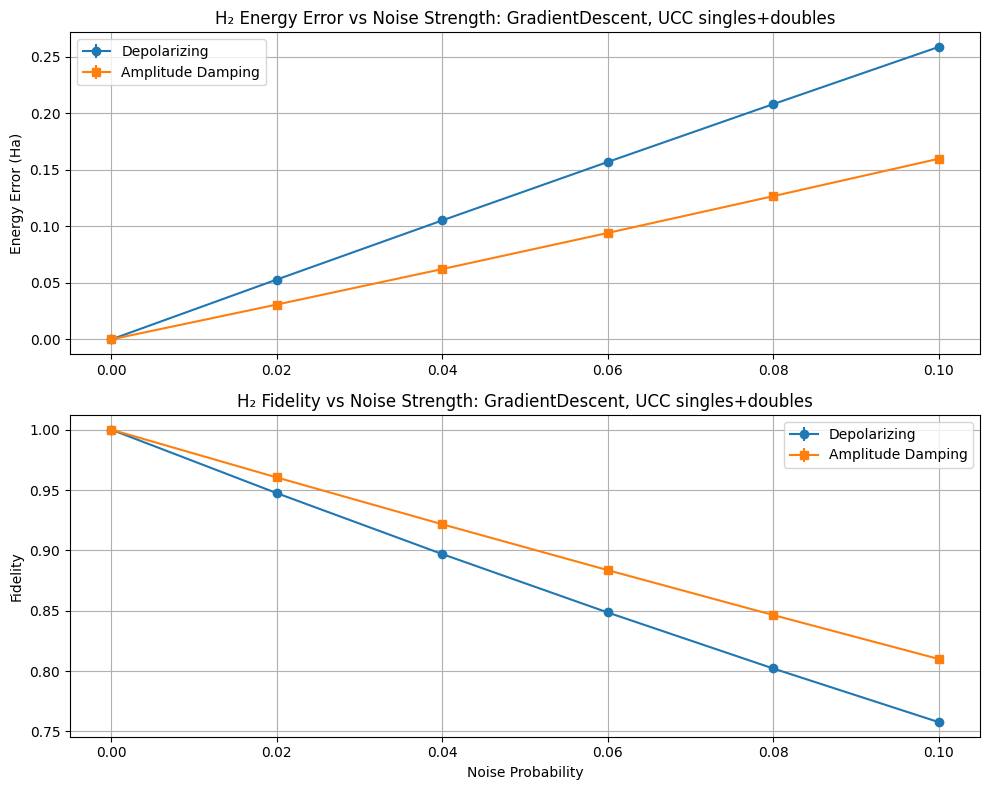

In [18]:
# Depolarizing results
energy_errors_dep, energy_error_stds_dep, fidelity_means_dep, fidelity_stds_dep = compute_noise_stats(
    noise_levels, dep_prob=1, amp_prob=0, optimizer_name=optimizer_name)

# Amplitude damping results
energy_errors_dep_amp, energy_error_stds_dep_amp, fidelity_means_dep_amp, fidelity_stds_dep_amp = compute_noise_stats(
    noise_levels, dep_prob=0, amp_prob=1, optimizer_name=optimizer_name)

# Energy subplot
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.errorbar(noise_levels, energy_errors_dep, yerr=energy_error_stds_dep, fmt='o-', label='Depolarizing')
plt.errorbar(noise_levels, energy_errors_dep_amp, yerr=energy_error_stds_dep_amp, fmt='s-', label='Amplitude Damping')
plt.ylabel("Energy Error (Ha)")
plt.title(f"H₂ Energy Error vs Noise Strength: {optimizer_name}, {ansatz_desc}")
plt.legend()
plt.grid(True)

# Fidelity subplot
plt.subplot(2,1,2)
plt.errorbar(noise_levels, fidelity_means_dep, yerr=fidelity_stds_dep, fmt='o-', label='Depolarizing')
plt.errorbar(noise_levels, fidelity_means_dep_amp, yerr=fidelity_stds_dep_amp, fmt='s-', label='Amplitude Damping')
plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title(f"H₂ Fidelity vs Noise Strength: {optimizer_name}, {ansatz_desc}")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Noise_Error_{optimizer_name}_{ansatz_desc}.png", dpi=300)
plt.show()


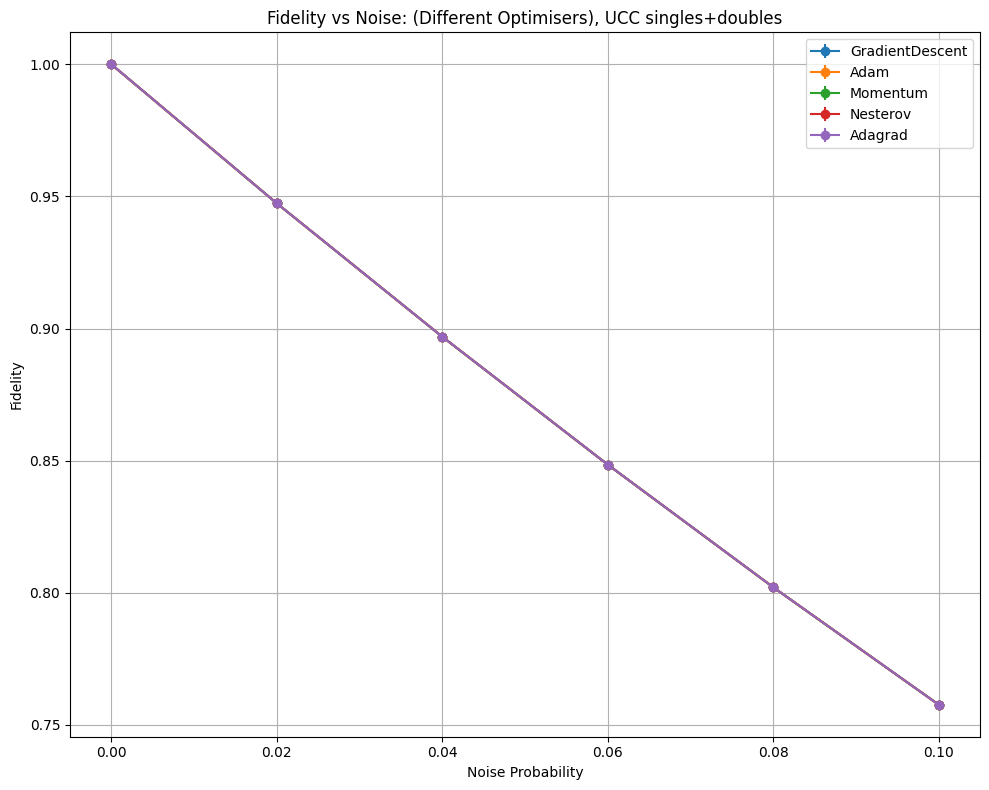

In [19]:
optimizers_to_test = ["GradientDescent", "Adam", "Momentum", "Nesterov", "Adagrad"]

plt.figure(figsize=(10,8))

for opt_name in optimizers_to_test:
    # Depolarizing only
    energy_errs, energy_err_stds, fidelities, fidelity_stds = compute_noise_stats(
        noise_levels, dep_prob=1, amp_prob=0, optimizer_name=opt_name)
    plt.errorbar(noise_levels, fidelities, yerr=fidelity_stds, fmt='o-', label=f'{opt_name}')

plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title(f"Fidelity vs Noise: (Different Optimisers), {ansatz_desc}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Noise_Error_Optimizer_Comparison_{ansatz_desc}.png", dpi=300)
plt.show()


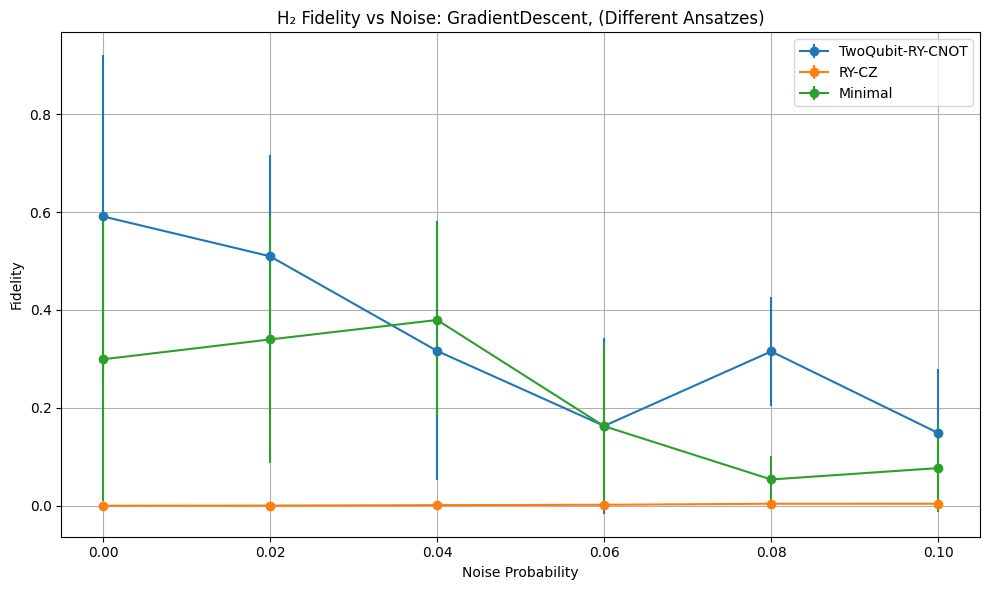

In [20]:
# Compare ansatzes over more seeds
# Extend run_vqe_with_cache to handle custom ansatz
def run_vqe_with_cache_ansatz(seed, ansatz_name, noisy=True, dep_prob=0.0, amp_prob=0.0, optimizer_name="Adam"):
    ansatz_fn = ANSATZES[ansatz_name]
    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_name,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
        noisy=noisy,
        depolarizing_prob=dep_prob,
        amplitude_damping_prob=amp_prob,
    )
    sig = run_signature(cfg)
    fname = os.path.join(RUNS_DIR, f"H2_Ansatz_Noise_s{seed}__{ansatz_name}__{sig}.json")
    existing = find_existing_run(RUNS_DIR, sig)

    if existing:
        with open(existing) as f:
            rec = json.load(f)
        energies = rec["energies"]
        params = np.array(rec["final_params"])
        final_state = np.array(rec["final_state_real"]) + 1j*np.array(rec["final_state_imag"])
        # Backfill to results/ if missing
        dest = os.path.join(RESULTS_DIR, os.path.basename(existing))
        if not os.path.exists(dest):
            with open(dest, "w") as f:
                json.dump(rec, f, indent=2)
        return energies, params, final_state
    else:
        # Initialize params: small random numbers
        params = init_params(ansatz_name, num_wires=num_wires, scale=0.01)
        # Define cost function
        cost_fn = get_vqe_qnode(ansatz_fn=ansatz_fn, noisy=noisy, return_state=False,
                                depolarizing_prob=dep_prob, amplitude_damping_prob=amp_prob)
        opt = get_optimizer(optimizer_name, stepsize=stepsize)

        energies = [cost_fn(params)]
        for _ in range(max_iterations):
            params, e_prev = opt.step_and_cost(cost_fn, params)
            energies.append(e_prev)

        final_state = get_vqe_qnode(ansatz_fn=ansatz_fn, noisy=noisy, return_state=True,
                                    depolarizing_prob=dep_prob, amplitude_damping_prob=amp_prob)(params)

        rec = {
            "config": cfg,
            "energies": np.asarray(energies).tolist(),
            "final_params": np.asarray(params).tolist(),
            "final_state_real": np.real(final_state).tolist(),
            "final_state_imag": np.imag(final_state).tolist(),
        }
        save_run_record(fname, rec)
        return energies, params, final_state


# Compute fidelity & energy statistics per ansatz
def compute_noise_stats_ansatz(noise_values, ansatz_name, dep_prob=0.0, amp_prob=0.0, optimizer_name="Adam"):
    energy_means, energy_stds = [], []
    fidelity_means, fidelity_stds = [], []

    for p in noise_values:
        results = [
            run_vqe_with_cache_ansatz(
                seed=s,
                ansatz_name=ansatz_name,
                noisy=True,
                dep_prob=(p if dep_prob else 0.0),
                amp_prob=(p if amp_prob else 0.0),
                optimizer_name=optimizer_name
            )
            for s in seeds
        ]
        noisy_energies = [r[0][-1] for r in results]
        errors = np.array(noisy_energies) - reference_energy
        energy_means.append(np.mean(errors))
        energy_stds.append(np.std(errors))

        fidelities = [fidelity(pure_state, r[2]) for r in results]
        fidelity_means.append(np.mean(fidelities))
        fidelity_stds.append(np.std(fidelities))

    return energy_means, energy_stds, fidelity_means, fidelity_stds

# Plot ansatz comparison under depolarizing noise only
plt.figure(figsize=(10, 6))
for ansatz_name in ANSATZES:
    _, _, fid_means, fid_stds = compute_noise_stats_ansatz(
        noise_levels, ansatz_name=ansatz_name, dep_prob=1, amp_prob=0, optimizer_name=optimizer_name
    )
    plt.errorbar(noise_levels, fid_means, yerr=fid_stds, fmt='o-', label=ansatz_name)

plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title(f"H₂ Fidelity vs Noise: {optimizer_name}, (Different Ansatzes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Noise_Error_Ansatz_Comparison_{optimizer_name}.png", dpi=300)
plt.show()
